## 1- Importing Libraries and Modules

This block imports necessary Python libraries and modules for data analysis, visualization, machine learning, and experiment tracking using CometML. The libraries include NumPy, Pandas, Matplotlib, Seaborn, Pathlib, Pickle, and scikit-learn's Logistic Regression. Additionally, it imports comet_ml for tracking experiments and "dataset" module for custom functionality.


In [1]:
# Importing necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import os

# Importing scikit-learn modules for logistic regression and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

# Importing CometML and dotenv for experiment tracking
from comet_ml import Experiment
from dotenv import load_dotenv

# Importing custom functionality from the "dataset" module
from dataset import Dataset

## 2 - Setting up Experiment and Directories

This block initializes an experiment using CometML, reads the API key from a file, and sets up directories for storing models and figures.


In [2]:
# Load environmental parameters
load_dotenv()

# Reading Comet API key from a file
key = os.environ.get("COMET_API_KEY")

# Setting up directories for data, models and figures
data_dir = Path("data")
models_dir = Path("models")
figs_dir = Path("figs")

# Initializing Comet experiments
experiment_plots = Experiment(
    api_key=key,
    project_name="ift6758-project-milestone2",
    workspace="ift6758-b09-project",
)

# Creating directories if they do not exist
if not models_dir.exists():
    models_dir.mkdir()
if not figs_dir.exists():
    figs_dir.mkdir()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/sepehr/Documents/UdeM/My-Courses/IFT6758B-Data-Science/Project/Milestone 2/code-base' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/82753ef385634c409970f11430d2997f



## 3 - Loading and Preprocessing Dataset

This block loads a tidy dataset from a CSV file, performs some initial preprocessing, and splits the data into training and testing sets.


In [3]:
# Download the dataset
logged_artifact = experiment_plots.get_artifact("dataset")
local_artifact = logged_artifact.download("data")

# Create an instance of dataset class
dataset = Dataset()

# Loading dataset from CSV file
train_data = pd.read_csv(data_dir / "train.csv", index_col=0)
test_regular_data = pd.read_csv(data_dir / "test_regular.csv", index_col=0)
test_playoff_data = pd.read_csv(data_dir / "test_playoff.csv", index_col=0)

COMET INFO: Artifact 'ift6758-b09-project/dataset:4.0.1' download has been started asynchronously
COMET INFO: Still downloading 3 file(s), remaining 61.25 MB/61.25 MB
COMET INFO: Artifact 'ift6758-b09-project/dataset:4.0.1' has been successfully downloaded


## 4 - Data Preparation and Logistic Regression Training Functions

This block defines functions for preparing data with specific features and training a logistic regression model.

- The `prepare_data` function splits the data, preprocesses it, and returns training and validation sets.

- The `train_log_reg` function trains a logistic regression model and returns predictions and probabilities.


In [4]:
# Function to prepare data with desired features
def prepare_data(data, desired_feats):
    data = dataset.preprocess(data, desired_feats + ["isgoal"])
    X, y = dataset.feat_label_split(data)
    X_train, X_val, y_train, y_val = dataset.train_val_split(X, y)
    return X_train, X_val, y_train, y_val

In [5]:
# Function to train a logistic regression model
def train_log_reg(X_train, X_val, y_train):
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_val)
    y_prob = log_reg.predict_proba(X_val)[:, 1]
    return log_reg, y_pred, y_prob

## 5 - Training and Saving Model - Shot Distance

This block prepares data based on shot distance, trains a logistic regression model, and saves the model and associated figures.


In [6]:
# Prepare data for shot distance
X_train, X_val, y_train, y_val = prepare_data(train_data, ["shot_distance"])
# Train logistic regression model
log_reg_dist, y_pred_dist, y_prob_dist = train_log_reg(X_train, X_val, y_train)
# Save the model
pickle.dump(log_reg_dist, open(models_dir / "log_reg_dist.sav", "wb"))

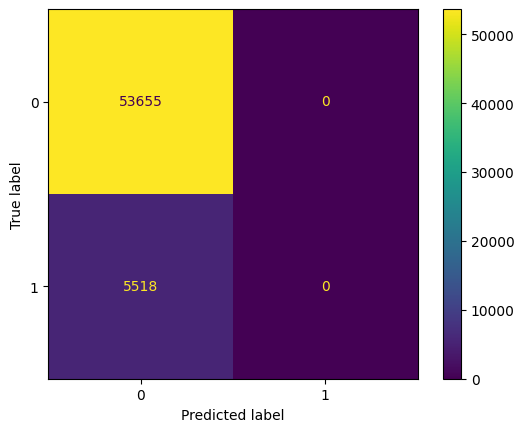

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     53655
           1       0.00      0.00      0.00      5518

    accuracy                           0.91     59173
   macro avg       0.45      0.50      0.48     59173
weighted avg       0.82      0.91      0.86     59173



In [7]:
# Visualizing confusion matrix
cm = confusion_matrix(y_val, y_pred_dist, labels=log_reg_dist.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_dist.classes_)
disp.plot()
disp.figure_.savefig(figs_dir / "conf_mat.png")
experiment_plots.log_figure(figure=disp.figure_, figure_name="conf_mat")
plt.show()

# Printing classification report
print(classification_report(y_val, y_pred_dist, zero_division=0))

# Log metrics
cr = classification_report(y_val, y_pred_dist, zero_division=0, output_dict=True)
metrics_dist = {"acc": cr["accuracy"]}

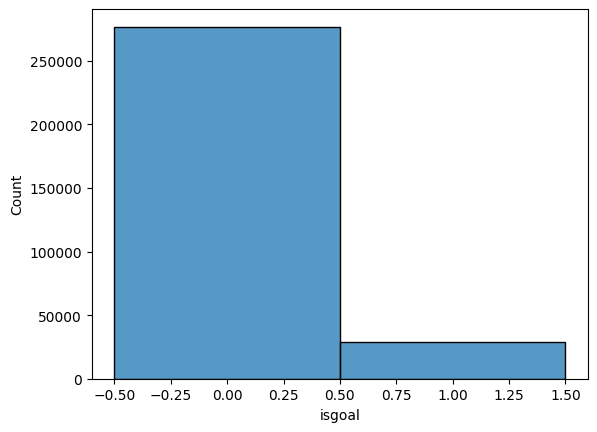

{'web': 'https://www.comet.com/api/image/download?imageId=f7092b182d2848c392edec8f4f5c702a&experimentKey=82753ef385634c409970f11430d2997f',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=f7092b182d2848c392edec8f4f5c702a&experimentKey=82753ef385634c409970f11430d2997f',
 'imageId': 'f7092b182d2848c392edec8f4f5c702a'}

In [8]:
# Visualizing histogram
fig = plt.figure()
sns.histplot(data=train_data, x="isgoal", discrete=True)
plt.show()
fig.savefig(figs_dir / "hist.png")
experiment_plots.log_figure(figure=fig, figure_name="hist")

## 6 - Training and Saving Model - Angle

Similar to Block 5, this block prepares data based on angle, trains a logistic regression model, and saves the model.


In [9]:
# Training logistic regression model for shot angle
X_train, X_val, y_train, y_val = prepare_data(train_data, ["angle"])
log_reg_ang, y_pred_ang, y_prob_ang = train_log_reg(X_train, X_val, y_train)
pickle.dump(log_reg_ang, open(models_dir / "log_reg_ang.sav", "wb"))

cr = classification_report(y_val, y_pred_ang, zero_division=0, output_dict=True)
metrics_ang = {"acc": cr["accuracy"]}

## 7 - Training and Saving Model - Distance and Angle

This block prepares data based on both shot distance and angle, trains a logistic regression model, and saves the model.


In [10]:
# Training logistic regression model for both distance and angle
X_train, X_val, y_train, y_val = prepare_data(train_data, ["shot_distance", "angle"])
log_reg_dist_ang, y_pred_dist_ang, y_prob_dist_ang = train_log_reg(
    X_train, X_val, y_train
)
pickle.dump(log_reg_dist_ang, open(models_dir / "log_reg_dist_ang.sav", "wb"))

cr = classification_report(y_val, y_pred_ang, zero_division=0, output_dict=True)
metrics_dist_ang = {"acc": cr["accuracy"]}

## 8 - Random Model Prediction

This block generates random predictions and probabilities for evaluation.


In [11]:
# Generating random predictions as a baseline
y_prob_rand = np.random.uniform(0, 1, y_val.shape)
y_pred_rand = np.where(y_prob_rand > 0.5, 1, 0)

## 9 - Plots


In [12]:
# Initialize the models name and probs list for future plots
models = ["random", "distance", "angle", "distance + angle"]
probs = [y_prob_rand, y_prob_dist, y_prob_ang, y_prob_dist_ang]
metrics = [None, metrics_dist, metrics_ang, metrics_dist_ang]

### 9.1 - ROC Curve

This block plots the ROC curve for different models based on their predicted probabilities.


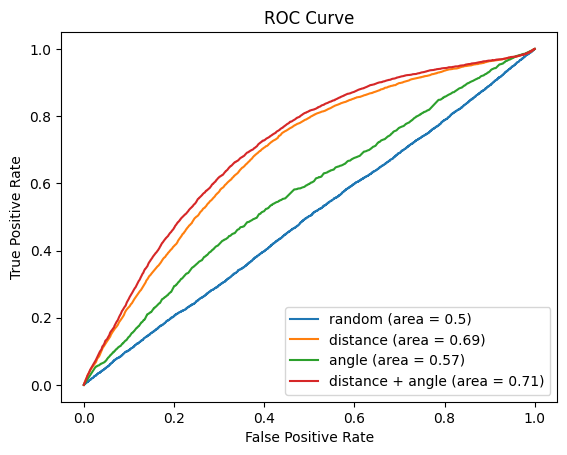

{'web': 'https://www.comet.com/api/image/download?imageId=4d52c8cf5b9641d98541cf5cce192675&experimentKey=82753ef385634c409970f11430d2997f',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=4d52c8cf5b9641d98541cf5cce192675&experimentKey=82753ef385634c409970f11430d2997f',
 'imageId': '4d52c8cf5b9641d98541cf5cce192675'}

In [13]:
# Plotting ROC curves for each model
fig = plt.figure()

for i in range(len(models)):
    fpr, tpr, _ = roc_curve(y_val, probs[i])
    roc_auc = auc(fpr, tpr)
    if metrics[i] != None:
        metrics[i]["roc"] = roc_auc
    plt.plot(fpr, tpr, label=f"{models[i]} (area = {round(roc_auc, 2)})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
fig.savefig(figs_dir / "roc.png")
experiment_plots.log_figure(figure=fig, figure_name="roc")

### 9.2 Percentile Analysis and Visualization

This block analyzes and visualizes goal rates and cumulative proportions based on model percentiles.


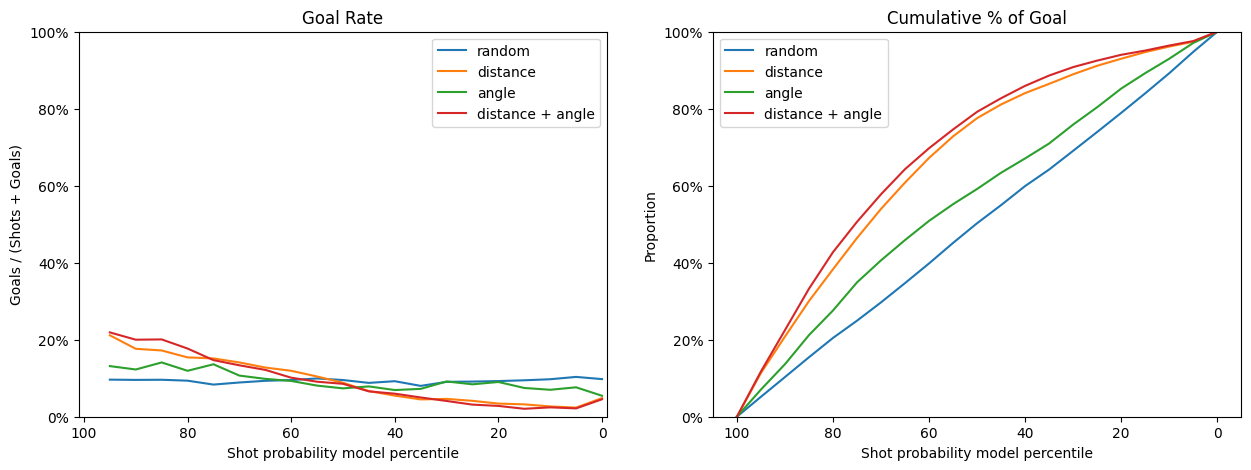

{'web': 'https://www.comet.com/api/image/download?imageId=8db32975bcc14317ae12f6c4b0f4b8ce&experimentKey=82753ef385634c409970f11430d2997f',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=8db32975bcc14317ae12f6c4b0f4b8ce&experimentKey=82753ef385634c409970f11430d2997f',
 'imageId': '8db32975bcc14317ae12f6c4b0f4b8ce'}

In [14]:
# Plotting goal rate and cumulative percentage of goal
bins = np.linspace(0, 95, num=20).astype(int)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Calculating percentiles and plotting for each model
list_plot_points = list()
for i in range(len(models)):
    perentiles = (np.argsort(np.argsort(probs[i])) + 1) * 100.0 / (len(probs[i]))
    perentile_bins = (np.digitize(perentiles, bins) - 1) * 5
    plot_points = pd.DataFrame(columns=["bin", "goal_rate", "goal_cum"])
    goal_cum = 0
    for j, bin in enumerate(np.flip(bins)):
        n_goal = np.sum(y_val[perentile_bins == bin])
        n_shot = np.sum(perentile_bins == bin)
        goal_rate = n_goal / n_shot
        goal_cum += n_goal / np.sum(y_val)
        plot_points.loc[j] = [bin, goal_rate, goal_cum]
    list_plot_points.append(plot_points)

    # Plotting goal rate
    sns.lineplot(
        data=plot_points,
        x="bin",
        y="goal_rate",
        legend=False,
        label="%s" % (models[i]),
        ax=axs[0],
    )

    # Plotting cumulative percentage of goal
    plot_points.loc[j + 1] = [100, 0, 0]
    sns.lineplot(
        data=plot_points,
        x="bin",
        y="goal_cum",
        legend=False,
        label="%s" % (models[i]),
        ax=axs[1],
    )

# Formatting and displaying plots
axs[0].set_title(f"Goal Rate")
axs[0].set_xlabel("Shot probability model percentile")
axs[0].set_ylabel("Goals / (Shots + Goals)")
axs[0].set_xlim(left=101, right=-1)
axs[0].set_ylim(bottom=0, top=1)
vals = axs[0].get_yticks()
axs[0].set_yticks(vals)
axs[0].set_yticklabels(["{:,.0%}".format(x) for x in vals])
axs[0].legend()

axs[1].set_title(f"Cumulative % of Goal")
axs[1].set_xlabel("Shot probability model percentile")
axs[1].set_ylabel("Proportion")
axs[1].set_xlim(left=105, right=-5)
axs[1].set_ylim(bottom=0, top=1)
vals = axs[1].get_yticks()
axs[1].set_yticks(vals)
axs[1].set_yticklabels(["{:,.0%}".format(x) for x in vals])
axs[1].legend()

plt.show()
fig.savefig(figs_dir / "goal_rate_cum.png")
experiment_plots.log_figure(figure=fig, figure_name="goal_rate_cum")

### 9.3 Calibration Curve for Model Evaluation

This block plots calibration curves for model evaluation.


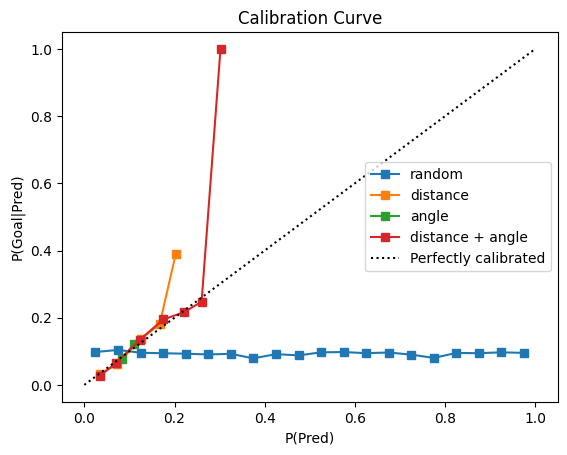

{'web': 'https://www.comet.com/api/image/download?imageId=5914b008b47b4eccb8fed5a4fea758ae&experimentKey=82753ef385634c409970f11430d2997f',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=5914b008b47b4eccb8fed5a4fea758ae&experimentKey=82753ef385634c409970f11430d2997f',
 'imageId': '5914b008b47b4eccb8fed5a4fea758ae'}

In [15]:
# Plotting calibration curve
fig = plt.figure()

# Plotting calibration curves for each model
for i in range(len(models)):
    prob_true, prob_pred = calibration_curve(y_val, probs[i], n_bins=20)
    plt.plot(prob_pred, prob_true, "s-", label="%s" % (models[i]))

# Formatting and displaying the plot
plt.title(f"Calibration Curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("P(Pred)")
plt.ylabel("P(Goal|Pred)")
plt.legend()

plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.show()
fig.savefig(figs_dir / "calibration.png")
experiment_plots.log_figure(figure=fig, figure_name="calibration")

In [16]:
# End the plot experiment
experiment_plots.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/82753ef385634c409970f11430d2997f
COMET INFO:   Downloads:
COMET INFO:     artifact assets : 3 (61.25 MB)
COMET INFO:     artifacts       : 1
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 5
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.


In [17]:
experiment_dist = Experiment(
    api_key=key,
    project_name="ift6758-project-milestone2",
    workspace="ift6758-b09-project",
)
experiment_dist.log_model("log_reg_dist", f"{models_dir}/log_reg_dist.sav")
experiment_dist.log_confusion_matrix(y_val, y_pred_dist)
experiment_dist.log_metrics(metrics_dist)
experiment_dist.add_tag("baseline_dist")
experiment_dist.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/sepehr/Documents/UdeM/My-Courses/IFT6758B-Data-Science/Project/Milestone 2/code-base' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/fd6f683bf9324bc4aafe732516e9ed38

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   

In [18]:
experiment_ang = Experiment(
    api_key=key,
    project_name="ift6758-project-milestone2",
    workspace="ift6758-b09-project",
)
experiment_ang.log_model("log_reg_ang", f"{models_dir}/log_reg_ang.sav")
experiment_ang.log_confusion_matrix(y_val, y_pred_ang)
experiment_ang.log_metrics(metrics_ang)
experiment_ang.add_tag("baseline_ang")
experiment_ang.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/sepehr/Documents/UdeM/My-Courses/IFT6758B-Data-Science/Project/Milestone 2/code-base' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/066eb71923294143887d23136514beb5

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   

In [19]:
experiment_dist_ang = Experiment(
    api_key=key,
    project_name="ift6758-project-milestone2",
    workspace="ift6758-b09-project",
)
experiment_dist_ang.log_model("log_reg_dist_ang", f"{models_dir}/log_reg_dist_ang.sav")
experiment_dist_ang.log_confusion_matrix(y_val, y_pred_dist_ang)
experiment_dist_ang.log_metrics(metrics_dist_ang)
experiment_dist_ang.add_tag("baseline_dist_ang")
experiment_dist_ang.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/sepehr/Documents/UdeM/My-Courses/IFT6758B-Data-Science/Project/Milestone 2/code-base' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/90775941400f48689503c7bacdc0ff09

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   